In [1]:
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
def image_arrs(paths, im_arr):
    for path in paths:
        #read images, may need to change filepath
        image = cv2.imread('../../GTSRB/'+path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize all images to 30x30
        size_image = image_from_array.resize((30, 30))
        #convert images to array
        image_arr = np.array(size_image.getdata(),
                        np.uint8).reshape(size_image.size[1], size_image.size[0], 3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [3]:
#this may take a minute
#may need to change file path
df = pd.read_csv('../../GTSRB/Train.csv')
#all filepaths for class 0-9
paths0 = df[(df['ClassId']==0)]['Path'].values
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values
paths3 = df[(df['ClassId']==3)]['Path'].values
paths4 = df[(df['ClassId']==4)]['Path'].values
paths5 = df[(df['ClassId']==5)]['Path'].values
paths6 = df[(df['ClassId']==6)]['Path'].values
paths7 = df[(df['ClassId']==7)]['Path'].values
paths8 = df[(df['ClassId']==8)]['Path'].values
paths9 = df[(df['ClassId']==9)]['Path'].values

class0_arrs = []
class0_arrs = image_arrs(paths0, class0_arrs)

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

class3_arrs = []
class3_arrs = image_arrs(paths3, class3_arrs)

class4_arrs = []
class4_arrs = image_arrs(paths4, class4_arrs)

class5_arrs = []
class5_arrs = image_arrs(paths5, class5_arrs)

class6_arrs = []
class6_arrs = image_arrs(paths6, class6_arrs)

class7_arrs = []
class7_arrs = image_arrs(paths7, class7_arrs)

class8_arrs = []
class8_arrs = image_arrs(paths8, class8_arrs)

class9_arrs = []
class9_arrs = image_arrs(paths9, class9_arrs)

In [4]:
#concat data and labels 
X = class0_arrs + class1_arrs + class2_arrs + class3_arrs + class4_arrs + class5_arrs +\
class6_arrs + class7_arrs + class8_arrs + class9_arrs
y = len(class0_arrs)*[0] + len(class1_arrs)*[1] + len(class2_arrs)*[2] + len(class3_arrs)*[3] +\
len(class4_arrs)*[4] + len(class5_arrs)*[5] + len(class6_arrs)*[6] + len(class7_arrs)*[7] +\
len(class8_arrs)*[8] + len(class9_arrs)*[9]

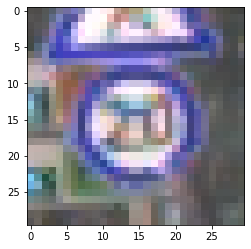

In [5]:
ex1 = X[0].reshape(30, 30, 3)
plt.imshow(ex1)

In [6]:
len(X)*.8/32

366.75

In [7]:
len(X)*.8

11736.0

In [8]:
#mean and std of each column is 0, 1
X = preprocessing.scale(X)

#split data
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), test_size=0.2, random_state=0)

In [9]:
#Convert from numpy array to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [10]:
class ANN(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear1 = nn.Linear(D, 1000)
        self.linear2 = nn.Linear(1000, 500)
        self.linear3 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
model = ANN(X_train.shape[1])

In [13]:
model.to(device);

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.00003)

In [15]:
#number of iterations
epochs = 600

#used to keep track of the changes in accuracy and loss
running_loss = 0
train_accs = []
test_accs = []
losses = []

#train on gpu
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

#training loop
for e in range(epochs):

    #standard training steps
    pred = model.forward(X_train)
    loss = criterion(pred, y_train)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #store current loss and accuracy for test and training set
    if e%25==0 and e>0:
        running_loss /= 100
#         print("epoch:", e, "loss", running_loss/100)
        losses.append(running_loss)
        running_loss = 0
        pred = torch.argmax(pred, axis=1)
        train_acc = torch.sum(pred==y_train).float()/len(pred)
#         print('training accuracy:', train_acc.item())
        train_accs.append(train_acc.item())
        test_pred = model.forward(X_test)
        test_pred = torch.argmax(test_pred, axis=1)
        test_acc = torch.sum(test_pred==y_test).float()/len(test_pred)
#         print('test accuracy:', test_acc.item())
        test_accs.append(test_acc.item())
print('Final training accuracy:', train_accs[-1])
print('Final test accuracy:', test_accs[-1])

Final training accuracy: 0.9400988817214966
Final test accuracy: 0.9021813273429871


In [16]:
print(pred[0])

tensor([-0.9753, -0.9820, -0.8896, -0.6270, -0.6092,  0.8808, -0.8568, -0.9157,
        -0.6473, -0.8328], device='cuda:0', grad_fn=<SelectBackward>)


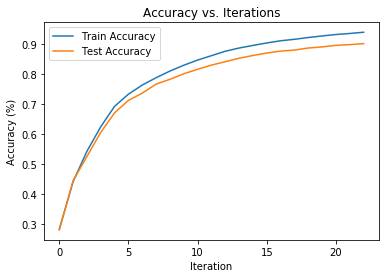

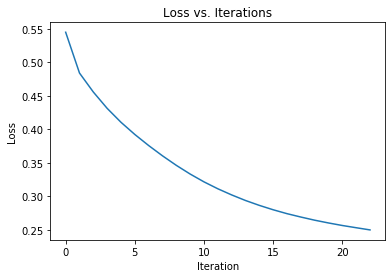

In [17]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
plt.plot(losses)
plt.title('Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [18]:
class ANN2(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear1 = nn.Linear(D, 500)
        self.linear2 = nn.Linear(500, 250)
        self.linear3 = nn.Linear(250, 125)
        self.linear4 = nn.Linear(125, 50)
        self.linear5 = nn.Linear(50, 25)
        self.linear6 = nn.Linear(25, 10)
        
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        x = torch.tanh(self.linear4(x))
        x = torch.tanh(self.linear5(x))
        x = torch.tanh(self.linear6(x))
        return x

In [19]:
model = ANN2(X_train.shape[1])
model.to(device);

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

In [21]:
#number of iterations
epochs = 700

#used to keep track of the changes in accuracy and loss
running_loss = 0
train_accs = []
test_accs = []
losses = []

#train on gpu
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

#training loop
for e in range(epochs):

    #standard training steps
    pred = model.forward(X_train)
    loss = criterion(pred, y_train)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #store current loss and accuracy for test and training set
    if e%25==0 and e>0:
        running_loss /= 100
#         print("epoch:", e, "loss", running_loss/100)
        losses.append(running_loss)
        running_loss = 0
        pred = torch.argmax(pred, axis=1)
        train_acc = torch.sum(pred==y_train).float()/len(pred)
#         print('training accuracy:', train_acc.item())
        train_accs.append(train_acc.item())
        test_pred = model.forward(X_test)
        test_pred = torch.argmax(test_pred, axis=1)
        test_acc = torch.sum(test_pred==y_test).float()/len(test_pred)
#         print('test accuracy:', test_acc.item())
        test_accs.append(test_acc.item())
print('Final training accuracy:', train_accs[-1])
print('Final test accuracy:', test_accs[-1])

Final training accuracy: 0.9718814492225647
Final test accuracy: 0.93592369556427


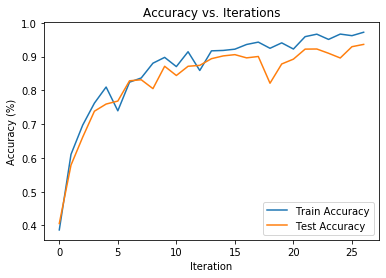

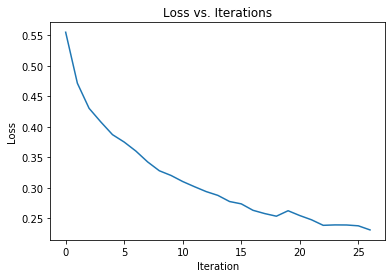

In [22]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
plt.plot(losses)
plt.title('Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()